In [153]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [154]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
epochs = 10
lr = 1e-3

def get_data(training_data, test_data):
    return (
        DataLoader(training_data), #, shuffle=True),
        DataLoader(test_data),
    )

train_dl, valid_dl = get_data(training_data, test_data)
train_dataloader = DataLoader(training_data, batch_size=1)
test_dataloader = DataLoader(test_data, batch_size=1)

Using cpu device


In [155]:
x1,y1 = next(iter(train_dl))
x1, y1 =x1.flatten(), y1.squeeze()
x1.shape, y1.shape

(torch.Size([784]), torch.Size([]))

In [156]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [157]:
def forward_one(dataloader, model, loss_fn, optimizer):
    X, y1 = next(iter(dataloader))
    X =  X[0][None,:]
    y1 = y1[None,:][:,0]
    pred = model(X)
    loss = loss_fn(pred, y1)
    return loss

In [158]:
def train_one(dataloader, model, loss_fn, optimizer):
    model.train()
    X, y1 = next(iter(dataloader))
    X =  X[0][None,:]
    y1 = y1[None,:][:,0]
    pred = model(X)
    loss = loss_fn(pred, y1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss

In [159]:
x1,y1 = next(iter(train_dl))
x1, y1 =x1.flatten(), y1.squeeze()
x1.shape, y1.shape

(torch.Size([784]), torch.Size([]))

In [120]:
# x1, y1 = next(iter(train_dataloader))
# x1 =  x1[0][None,:]
# y1 = y1[None,:][:,0]
# y1

In [160]:
torch.manual_seed(0)
model = NeuralNetwork().to(device)
torch.save(model.state_dict(), "tinymodel.pth")
model.load_state_dict(torch.load('tinymodel.pth'))
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [161]:
state_dict = torch.load('tinymodel.pth')
weights = []
weights.append(state_dict['linear_relu_stack.0.weight'].clone())
weights.append(state_dict['linear_relu_stack.2.weight'].clone())
bias = []
bias.append(state_dict['linear_relu_stack.0.bias'].clone())
bias.append(state_dict['linear_relu_stack.2.bias'].clone())

In [178]:
def relu(X):
    X[X<0] = 0
    return X

def d_relu(l):
    d = a[l].clone()
    d[a[l] < 0] = 0
    d[a[l] > 0] = 1
    return d

def softmax(x):
    return x.exp() / x.exp().sum()

def delta_l(y_pred, y, l):
    if l == len(weights)-1: # This means it's the last layer... must be a vector
        y_ = torch.zeros(len(y_pred))
        y_[y] = 1
        return (y_pred - y_)[None,:]
    else:
        return (weights[l+1].T@delta_l(y_pred,y,l+1).T)@d_relu(l)
    
activations = []
activations.append(relu)
activations.append(softmax)
    
def forward(X):
    a = [X]
    
    for w,b,func in zip(weights, bias, activations):
        a.append(func(a[-1]@w.T+b))
    return a

def cross_entropy(y_pred,y):
    return -y_pred[y].log()

def backward(y_pred,y): # hard-wired backprop...
    loss_L = delta_l(y_pred,y1,1)
    weights[1] -= lr * (a[1][None,:].T@loss_L).T
    bias[1] -= lr * loss_L.squeeze()

    loss_l = ((weights[1].T@delta_l(y_pred,y,1).T).T*d_relu(1))

    weights[0] -= lr * (a[0][None,:].T@loss_l).T
    bias[0] -= lr * loss_l.squeeze()
        
    loss = cross_entropy(y_pred,y)
    return loss



<Axes: >

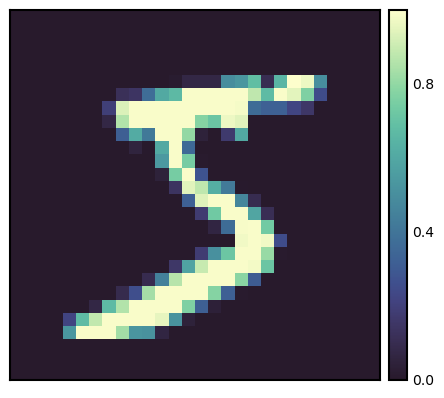

In [124]:
import seaborn_image as isns
isns.imgplot(x1.reshape(28,28))

In [163]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
train_one(train_dataloader, model, loss_fn, optimizer)

tensor(2.3997, grad_fn=<NllLossBackward0>)

In [164]:
a = forward(x1)
cross_entropy(a[-1],y1)
backward(a[-1],y1)

tensor(2.3997)

In [165]:
bool(not sum(bias[-2] != model.state_dict()['linear_relu_stack.0.bias']))

False

In [166]:
bool(not sum(bias[-1] != model.state_dict()['linear_relu_stack.2.bias']))

True

In [173]:
bool(not (weights[-2] != model.state_dict()['linear_relu_stack.0.weight']).sum())

False

In [168]:
bool(not (weights[-1][y1] != model.state_dict()['linear_relu_stack.2.weight'][y1]).sum())

True

In [169]:
(weights[-2] != model.state_dict()['linear_relu_stack.0.weight']).sum()

tensor(812)

In [175]:
(weights[-2] != model.state_dict()['linear_relu_stack.0.weight'])

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [176]:
weights[-2], model.state_dict()['linear_relu_stack.0.weight']

(tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0237,  0.0103, -0.0219,  ...,  0.0088, -0.0009,  0.0009],
         [ 0.0144, -0.0336, -0.0346,  ..., -0.0222, -0.0025, -0.0138],
         [-0.0196, -0.0118,  0.0230,  ..., -0.0202,  0.0172,  0.0355]]),
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0237,  0.0103, -0.0219,  ...,  0.0088, -0.0009,  0.0009],
         [ 0.0144, -0.0336, -0.0346,  ..., -0.0222, -0.0025, -0.0138],
         [-0.0196, -0.0118,  0.0230,  ..., -0.0202,  0.0172,  0.0355]]))

In [177]:
model.state_dict()['linear_relu_stack.0.weight']

tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
        [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
        [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
        ...,
        [ 0.0237,  0.0103, -0.0219,  ...,  0.0088, -0.0009,  0.0009],
        [ 0.0144, -0.0336, -0.0346,  ..., -0.0222, -0.0025, -0.0138],
        [-0.0196, -0.0118,  0.0230,  ..., -0.0202,  0.0172,  0.0355]])